# Un peu de géométrie

Avant d'entrer dans le vif du sujet, nous devons nous intéresser un instant sur quelques considérations géométriques. Parlons des homographies…

## Différents types d'homographies

Une homographie est une transformation d'un espace Euclidien qui préserve l'alignement des points (une droite qui subit une homographie est toujours une droite). En français, on utilise aussi parfois le terme d'application projective pour désigner cette classe de transformations. Les homographies sont des transformations qui vont s'appliquer sur les *coordonnées* d'une image et ainsi déplacer les pixels, produisant une image différente.

Il existe plusieurs types d'homographies que nous allons lister de la plus simple à la plus complexe.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import feature

plt.rcParams['figure.figsize'] = (10, 10)

### Transformation rigide

Une transformation rigide (ou une transformation Euclidienne) est une transformation qui préserve la distance entre toutes les paires de points de l'espace en question. Concrètement, une transformation rigide est la composition d'une rotation autour de l'origine suivie par une translation.

Elle s'écrit sous forme matricielle :

$$M = \begin{bmatrix}
\cos \theta & -\sin\theta & t_x\\
\sin \theta & \cos\theta & t_y\\
0 & 0 & 1\\
\end{bmatrix}$$

avec $\theta$ l'angle de la rotation et $\vec{\mathbf{t}} = (t_x, t_y)$ le vecteur de translation.

Elle s'applique sur les coordonnées *homogènes* de la grille de pixels, c'est-à-dire sur le vecteur $\mathbf{\vec{X}}$ défini par:

$$\mathbf{\vec{X}} = \begin{bmatrix}
x\\
y\\
1\\
\end{bmatrix}$$


`skimage` rend particulièrement simple la manipulation de ces transformations puisqu'il est possible de créer directement un objet `EuclideanTransform` en passant les paramètres $\theta$ et $\vec{\mathbf{t}}$ :

In [ ]:
from skimage import transform

tform = transform.EuclideanTransform(rotation=np.pi/4, translation=(50, -20))
print(tform.params)

Émerveillons-nous devant la matrice ci-dessous, correspondant à la transformation euclidienne désirée et calculée automatiquement par `scikit-image`.

Nous pouvons alors appliquer la transformation sur une image de notre choix. Pour obtenir l'image transformée, de façon quelque peu contre-intuitive, il faut appliquer la transformation *inverse* sur les coordonnées (pour retrouver pour chaque pixel de l'image de *sortie* la coordonnée du pixel *d'entrée* correspondant) :

In [ ]:
cat = skimage.data.cat()
cat_tf = transform.warp(cat, tform.inverse)
plt.imshow(cat)
plt.show()
plt.imshow(cat_tf)
plt.show()

**Question** : où se trouve l'origine du plan de l'image ?

Remarquons que `skimage` peut inverser automatiquement la transformation (ce qui revient à calculer la matrice $M^{-1}$, inverse de la matrice $M$).

In [ ]:
plt.imshow(transform.warp(cat_tf, tform)) and plt.show()

**Question** : que constatez-vous ? Pourquoi ?
    
*Note* : pour information, on peut modifier le paramètre `output_shape` de la fonction `warp` pour éviter ce problème, mais c'est un détail.

## Similitudes

Une similitude est une transformation qui conserve les formes, c'est-à-dire qu'elle conserve *les rapports entre les distances*. Il s'agit de la composition d'une rotation autour de l'origine, d'une rotation et d'une dilatation. Sa matrice s'écrit (en coordonnées homogènes) :

$$S = \begin{bmatrix}
d \cdot \cos \theta & - d \cdot \sin\theta & t_x\\
d \cdot \sin \theta & d \cdot \cos\theta & t_y\\
0 & 0 & 1\\
\end{bmatrix}$$

avec $d$ le facteur de dilation (ou *zoom* ou mise à l'échelle), $\theta$ l'angle de la rotation et $\vec{\mathbf{t}} = (t_x, t_y)$ le vecteur de translation.

In [ ]:
tform = transform.SimilarityTransform(
    scale=0.5,
    rotation=np.pi/12,
    translation=(100, 50))
print(tform.params)
cat_tf = transform.warp(cat, tform.inverse)
plt.imshow(cat_tf) and plt.show()

### Transformation affine

Une transformation affine préserve les droites et le parallélisme. C'est la composition d'une similitude et d'une [transvection](https://fr.wikipedia.org/wiki/Transvection) (ou *shearing*). Sa matrice s'écrit :


$$A = \begin{bmatrix}
d \cdot \cos \theta & - d \cdot \sin(\theta + s) & t_x\\
d \cdot \sin \theta & d \cdot \cos(\theta + s) & t_y\\
0 & 0 & 1\\
\end{bmatrix}$$

avec $s$ le facteur de transvection (*shearing*), $d$ le facteur de dilation (ou *zoom* ou mise à l'échelle), $\theta$ l'angle de la rotation et $\vec{\mathbf{t}} = (t_x, t_y)$ le vecteur de translation.

In [ ]:
tform = transform.AffineTransform(
        shear=np.pi/6,
        )
print(tform.params)
cat_tf = transform.warp(cat, tform.inverse)
plt.imshow(cat_tf) and plt.show()

### Applications projectives

Enfin, les homographies à proprement parler (les transformations précédentes en sont des cas particuliers) préservent les droites mais pas forcément le parallélisme. Il s'agit d'une transformation dont la matrice a pour forme générale :


$$H = \begin{bmatrix}
a_0 & a_1 & a_2\\
b_0 & b_1 & b_2\\
c_0 & c_1 & 1\\
\end{bmatrix}$$

In [ ]:
matrix = np.array([[1, -0.5, 100],
                   [0.1, 0.9, 50],
                   [0.0015, 0.0015, 1]])
tform = transform.ProjectiveTransform(matrix=matrix)
cat_tf = transform.warp(cat, tform.inverse)
plt.imshow(cat_tf) and plt.show()

# Extraction de points d'intérêt

Après cet intermède géométrique, revenons à nos moutons. L'objectif de cette séance est d'identifier des points *d'intérêt* dans une image. À quelle fin ? Voyons sur un exemple.

In [ ]:
text = skimage.data.text()
plt.imshow(text, cmap="gray") and plt.axis("off") and plt.show()

Cette photo représente du texte manuscrit mais la perspective n'est pas droite. Il y a une application projective qui déforme le plan du papier par rapport au plan de la prise de vue (le plan normal à la ligne de visée). Il existe donc une matrice d'homographie $H$ qui permettrait de « redresser » le texte mais bien sûr on le connait pas.

Et si on pouvait la deviner ?

Admettons que je place manuellement 4 points dans l'image dont je sais qu'ils devraient a priori former un rectangle (même approximatif) :

In [ ]:
keypoints = np.array([[155, 15], [65, 40], [260, 130], [360, 95]])
plt.imshow(text, cmap="gray")
plt.plot(keypoints[:, 0], keypoints[:, 1], '.r', markersize=20)
plt.show()

L'homographie que l'on cherche placerait ces 4 points aux coins d'un rectangle. Imposons par exemple que le rectangle parfait pour nous aurait une hauteur 50 pixels et une largeur 300 pixels, les coordonnées des coins sont donc :

In [ ]:
rectangle = np.array([[0, 0], [0, 50], [300, 50], [300, 0]])

Pour chaque point, cela nous donne donc $W_i = H V_i$ avec $W$ les coins du rectangle en coordonnées homogènes et $V$ les points d'intérêt marqués manuellement dans l'image.

En réalité, cela donne le système d'équation suivant :

$$\begin{bmatrix}x'_i\\ y'_i \\ 1\end{bmatrix} = \begin{bmatrix}
a_0 & a_1 & a_2\\
b_0 & b_1 & b_2\\
c_0 & c_1 & 1\\
\end{bmatrix}
\begin{bmatrix}x_i\\ y_i \\ 1\end{bmatrix}$$

où $x_i, y_i, x'_i, y'_i$ sont connus. Ce système d'équations peut se résoudre de façon exacte si l'on a suffisamment de couples de points (il y a 8 inconnus, il faut donc au minimum 4 points non colinéaires pour déterminer l'homographie). 

À défaut, on peut utiliser la méthode des moindres carrés pour trouver une solution approchée :
$$H^* = \min_{H} \| X' - H \cdot X \|^2$$

*Note* : cela fonctionne aussi les certaines des valeurs $x_i, y_i, x'_i, y'_i$ sont incorrectes.

Avec `scikit-image`, cette estimation se fait grâce à la méthode `estimate`, ce qui donne :

In [ ]:
tform = transform.ProjectiveTransform()
# on cherche la transformation qui met les coordonnées du rectangle dans celles des points d'intérêt de l'image
tform.estimate(rectangle, keypoints)
corrected_text = transform.warp(text, tform, output_shape=(50, 300))
plt.imshow(corrected_text, cmap="gray") and plt.show()

Magie ! Le texte est redressé grâce à la transformation projective que nous avons estimé. 

Pour la suite, deux questions se posent.

1. Tout d'abord, nous avons ici défini les points d'intérêt manuellement mais il est sûrement possible de faire mieux. Peut-être pourrions nous définir un critère qui permet de décider si un pixel de l'image est oui ou non « intéressant ».

2. L'autre problème, plus subtil, est que pour construire le système d'équation précédent, il faut savoir comment associer un point d'intérêt de l'image $A$ à un point d'intérêt de l'image $B$. Ici, nous l'avons fait à la main. Mais dans le cas général, ce n'est pas si simple et il faudra trouver une procédure *d'appariement* pour créer les paires de points d'intérêt. 

## Détecteur de coins de Moravec

Commençons par résoudre la question : comment trouver des points d'intérêt dans une image ? On pourrait arguer que tous les pixels sont intéressants (ou que l'intérêt d'un point est une notion quasi-philosophique) mais cela ne nous avance pas beaucoup.

Un premier type (et le plus simple) de points d'intérêt dans une image sont les coins : ils correspondent à l'intersection entre des contours et sont donc assez caractéristiques de la structure de l'image.

Un algorithme simple mais efficace de détection de coin est l'algorithme de Moravec. En 1980, le roboticien Hans Moravec¹ définit un coin comme étant un point avec une faible auto-similarité, c'est-à-dire le centre d'une fenêtre de l'image (un *patch*) qui ne ressemble pas aux fenêtres voisines.

¹ [*Obstacle Avoidance and Navigation in the REal World by a Seeing Robot Rover*](https://www.ri.cmu.edu/publications/obstacle-avoidance-and-navigation-in-the-real-world-by-a-seeing-robot-rover/)

L'algorithme de Moravec consiste à calculer pour chaque point de l'image la somme des différences au carré entre une fenêtre centrée en $(x,y)$ et sa voisine translatée d'un vecteur $(u,v)$ :

$$E(u,v) = \sum_{x,y} w(x, y) | I(u + x, v + y) - I (x, y) |^2$$

avec $w$ une fonction qui spécifie la fenêtre considérée ($w(u,v) = 1$ à l'intérieur de la fenêtre et 0 à l'extérieur).

En pratique, on va considérer 8 translations possibles :
- gauche $(-1, 0)$ et droite $(+1, 0)$,
- haut $(0, -1)$ et bas $(0, +1)$,
- diagonale gauche/haut $(-1, -1)$ et diagonale bas/droite $(+1, +1)$,
- anti-diagonale gauche/bas $(-1, +1)$ et anti-diagonale droite/haut $(+1, -1)$,

et on définit l'intensité du coin de Moravec comme étant $\min E(u,v)$. Autrement dit, un pixel aura une haute détection de coin si *toutes* les fenêtres translatées par $(u,v)$ sont différentes de la fenêtre centrée sur le pixel.

Sur un exemple simple (un carré), cela donne :

In [ ]:
from skimage.feature import corner_moravec

square = np.zeros([100, 100], dtype="int")
square[20:80, 20:80] = 1

moravec = corner_moravec(square)

fig = plt.figure()
fig.add_subplot(121)
plt.imshow(square, cmap="gray")
plt.title("Carré")
fig.add_subplot(122)
plt.imshow(moravec, cmap="gray")
plt.title("Intensité de Moravec")
plt.show()

On remarque que l'on peut distinguer 3 cas :
- si l'intensité est constante (zone homogène), $E$ est faible,
- si le pixel appartient à un contour rectiligne, $E$ est faible dans le sens du contour et fort selon la perpendiculaire au contour,
- si le pixel est près d'un coin, $E$ est très forte dans toutes les directions.

L'idée du détecteur est donc ensuite de rechercher les maxima locaux de $E$ :

In [ ]:
from skimage.feature import corner_peaks

corners = feature.corner_peaks(moravec,)
plt.imshow(square, cmap="gray")
for (y, x) in corners:
    plt.plot(x, y, marker="+", markersize=20)
plt.show()

## Détecteur de Harris

Le détecteur de Moravec est efficace mais ne fonctionne que dans des cas limités du fait de sa simplicité. Le détecteur de Harris est en pratique nettement plus puissant (et il est beaucoup plus populaire). Son fonctionnement est un peu plus complexe. Il a été introduit en 1988 par Harris et Stephens².

²: [*A combined corner and edge detector*](http://www.bmva.org/bmvc/1988/avc-88-023.pdf)

Le principe du détecteur de Harris est considérer le développement limité du premier ordre de la fonction d'intensité $I$ de l'image au voisinage d'un pixel $(u,v)$ :

$$I(x + u, y + v) \approx I(u,v) + x \frac{\delta I}{\delta x} + y \frac{\delta I}{\delta y}$$

donc la fonction $E$ peut se réécrire :

$$E(x,y) \approx \sum_{u,v} w(u,v) [x \frac{\delta I}{\delta x} + y \frac{\delta I}{\delta y}]^2$$

$$E(x,y) \approx \sum_{u,v} w(u,v) [\frac{\delta I}{\delta x}^2 x^2 + \frac{\delta I}{\delta y}^2 y^2 + 2\frac{\delta I}{\delta x}\frac{\delta I}{\delta y} xy]$$

Matriciellement, cela revient à écrire :
    
$$E(x,y) \approx \begin{bmatrix}x & y\end{bmatrix} M \begin{bmatrix}x\\y\end{bmatrix}$$

où $M$ est une matrice qui s'exprime en fonction des gradients $G_x = \frac{\delta I}{\delta x}$ et $G_y = \frac{\delta I}{\delta y}$ :

$$M_{x,y} = w \otimes \begin{bmatrix}G_x^2 & G_x G_y\\ G_x G_y & G_y^2\end{bmatrix}$$

Plutôt que de considérer la fonction $E$, Harris et Stephen proposent comme détecteur de coin l'opérateur $R$ défini par :
$$R(x,y) = \det(M_{x,y}) - k \operatorname{Trace}(M_{x,y})^2$$

L'intuition est la suivante :
- quand $|R|$ est faible, cela signifie que les deux valeurs propres $\lambda_1$ et $\lambda_2$ de la matrice $M$ sont faibles : le gradient est faible dans toutes les directions et la région est homogène,
- quand $R \lt 0$, alors $\lambda_1 \gg \lambda_2$  ou $\lambda_2 \gg \lambda_1$. Autrement dit, il y a une direction dans laquelle le gradient est très forte (mais le gradient dans la direction perpendiculaire est faible) : il s'agit d'un contour,
- enfin, quand $R$ est grand, cela veut dire que $\lambda_1$ et $\lambda_2$ sont grands : il y a donc deux gradients élevés perpendiculaires autour du point considéré, ce qui est la définition même d'un coin !

Enfin, dernière subtilité, Harris et Stephen proposent en outre de remplacer la fenêtre rectangulaire par une fenêtre gaussienne :
    
$$w(u,v) = e^{-\frac{u^2 + v^2}{2\sigma^2}}$$

Dans `scikit-image`, c'est la fonction `corner_harris` qui implémente le calcul du détecteur de coin $R$ :

In [ ]:
harris = feature.corner_harris(square)
corners = feature.corner_peaks(harris, threshold_rel=0.1)

In [ ]:
plt.imshow(square, cmap="gray")
for (y, x) in corners:
    plt.plot(x, y, marker="+", markersize=20)

## Appariement des points d'intérêts

Le problème de l'appariemment consiste à mettre en correspondance une liste de $m$ points $P = p_1, \dots, p_m$ avec une liste de $m$ points $Q = q_1, \dots, q_m$. L'objectif est de produire une liste de $\min(m,n)$ couples.

Pour ce faire, la méthode canonique consiste à attribuer un score à chaque paire, c'est-à-dire une fonction $s : i, j \rightarrow s(i,j)$.

Ensuite, pour chaque point $p_i$, on pourra lui assigner comme binôme le point $q_{j*}$ tel que :
$$s(p_i, q_{j*}) = \max_{1 \leq j \leq n} s(p_i, q_j)$$

ou, autrement dit, le point d'intérêt de la deuxième liste qui a le score de similarité le plus élevé.

En pratique, il est rare que l'on considère un score de similarité : on cherchera plutôt à minimiser une distance $d$ (mais le principe est le même).

Une subtilité est que cette approche n'est pas symétrique : le fait que $q_j$ soit le point d'intérêt dans $Q$ qui maximise le score pour $p_i$ ne signifie pas qu'il n'y a pas d'autre point $p \in P$ qui a un score plus élevé vis-à-vis de $q_j$. On peut donc parfois imposer la contrainte de symétrie : on ne conserve que les couples qui sont mutuellement le maximum l'un par rapport à l'autre, c'est-à-dire :

$$s(p_i, q_j) = \max_{1 \leq j' \leq n} s(p_i, q_j')$$
et
$$s(p_i, q_j) = \max_{1 \leq i' \leq m} s(p_i', q_j)$$

Pour illustrer cette problématique, prenons deux images qui diffèrent par une transformation affine :

In [ ]:
from skimage.color import rgb2gray
from skimage.exposure import rescale_intensity
from skimage.util import img_as_float

# Grille noir/blanc
checkerboard = img_as_float(skimage.data.checkerboard())
img_orig = np.zeros(list(checkerboard.shape) + [3])
img_orig[..., 0] = checkerboard
gradient_r, gradient_c = (np.mgrid[0:img_orig.shape[0],
                                   0:img_orig.shape[1]]
                          / float(img_orig.shape[0]))
img_orig[..., 1] = gradient_r
img_orig[..., 2] = gradient_c
img_orig = rescale_intensity(img_orig)
img_orig = rgb2gray(img_orig)


# Transformation de l'image
tform = transform.AffineTransform(rotation=0.2, translation=(20, -10))
img_warped = transform.warp(img_orig, tform.inverse, output_shape=(200, 200))

fig = plt.figure(figsize=(12, 6))
fig.add_subplot(121)
plt.title("Image originale")
plt.imshow(img_orig, cmap="gray")
fig.add_subplot(122)
plt.title("Image transformée")
plt.imshow(img_warped, cmap="gray")
plt.show()

Appliquons le détecteur de coin de Harris sur les deux images. Cela nous donne les listes de points d'intérêt $p$ et $q$. Notons que le nombre de points d'intérêts n'est pas identique dans les deux images !

In [ ]:
from skimage.feature import corner_harris, corner_peaks

coords_orig = corner_peaks(corner_harris(img_orig), threshold_rel=0.001, min_distance=5)
coords_warped = corner_peaks(corner_harris(img_warped), threshold_rel=0.001, min_distance=5)

fig = plt.figure(figsize=(12, 6))
fig.add_subplot(121)
plt.title(f"Image originale ({len(coords_orig)} keypoints)")
plt.imshow(img_orig, cmap="gray")
plt.scatter(coords_orig[:,1], coords_orig[:,0], marker="+", color="b", s=200)
fig.add_subplot(122)
plt.title(f"Image transformée ({len(coords_warped)} keypoints)")
plt.imshow(img_warped, cmap="gray")
plt.scatter(coords_warped[:,1], coords_warped[:,0], marker="+", color="r", s=200)
plt.show()

Pour estimer la matrice de transformation qui permet de passer de l'image de gauche à l'image de droite, nous avons besoin de former les couples de points $(p_i, q_j)$ et donc de mettre en correspondance les points d'intérêt de l'image originale avec ceux de l'image transformée.

### Méthode des sommes des carrés des différences

Une technique (un peu brutale) pour réaliser la mise en correspondance des points d'intérêts consiste à comparer les paires de fenêtres de dimensions $k_x \times k_y$ centrée sur les points d'intérêts

Considérons deux images $I_1$ et $I_2$ et leurs ensembles respectifs de points d'intérêts $p_1, \dots, p_m$ et $q_1, \dots, q_n$. Le problème de l'appariemment de calculer pour chaque paire $(p_i, q_j)$ un score $d(p_i,q_j)$. On se propose d'ici d'utiliser la somme des carrés des différences des sous-fenêtres centrées en $p_i$ et $q_j$ :

$$d(p_i, q_j) = \sum_{-k/2 \leq u, v \leq +k/2} | I_1(p_{x, i} + u, p_{y, i} + v) - I_2(q_{x, j} + u, q_{y, j} + v)|^2$$

Et on utilise la procédure d'appariemment décrite précédemment.

Concrètement, cela consiste à appairer les points d'intérêt qui présentent visuellement les mêmes motifs. Malheureusement, en utilisant les différences entre images, on retrouve toutes les limitations de ces approches de comparaison visuelles :
- pas d'invariance au changement de luminosité,
- pas d'invariance aux changements de couleur,
- espace RGB peu adapté à la différence entre couleurs.

C'est toutefois en général la meilleure solution lorsque que l'on ne possède que les coordonnées des points d'intérêt.

In [ ]:
def match_corner(coord, other_coords, window_ext=5):
    r, c = coord
    window_orig = img_orig[r-window_ext:r+window_ext+1,
                           c-window_ext:c+window_ext+1]


    # Calcule la somme des différences au carré (sum of squared differences)
    SSDs = []
    # on calcule la SSD pour chaque fenêtre de la deuxième image
    for cr, cc in other_coords:
        window_warped = img_warped[cr-window_ext:cr+window_ext+1,
                                   cc-window_ext:cc+window_ext+1]
        SSD = np.sum((window_orig - window_warped)**2)
        SSDs.append(SSD)

    # On choisit le coin qui a la meilleure correspondance (SSD la plus faible)
    min_idx = np.argmin(SSDs)
    return min_idx


# Calcul de la liste des correspondances
matches = []
src, dst = [], []
for idx, coord in enumerate(coords_orig):
    src.append(coord)
    best = match_corner(coord, coords_warped)
    dst.append(coords_warped[best])
    matches.append([idx, best])

matches = np.array(matches)
src = np.array(src)
dst = np.array(dst)

La fonction `plot_matches` de `scikit-image` permet de facilement visualiser l'appariemment des points d'intérêts des deux images :

In [ ]:
from skimage.feature import plot_matches
fig, ax = plt.subplots(nrows=1, ncols=1)
plot_matches(ax, img_orig, img_warped, coords_orig, coords_warped, matches, matches_color='b')

**Question** : que constatez-vous ? En quoi cela va poser problème pour l'estimation de la matrice d'homographie ?

In [ ]:
tform = transform.AffineTransform()
tform.estimate(src, dst)
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
ax[0].imshow(img_orig, cmap="gray")
ax[0].set_title("Image originale")
ax[1].imshow(transform.warp(img_warped, tform.inverse), cmap="gray")
ax[1].set_title("Image redressée")
plt.show()

**Question** : ce résultat correspond-il à vos attentes ? Pourquoi ?

### RANSAC

Comme nous avons beaucoup de correspondances, il va nous falloir trier celles qui sont correctes et celles qui ne le sont pas. Pour ce faire, nous allons utiliser l'algorithme RANSAC : *RANdom SAmple Consensus*³. Le principe de RANSAC est de sélectionner aléatoirement un certain nombre de correspondances, estimer la transformation correspondante, évaluer cette transformation (on calcule l'écart entre les points d'intérêt prédits par cette transformation et ceux que l'on a réellement) et on recommence.

³: [*Random sample consensus: a paradigm for model fitting with applications to image analysis and automated cartography*, Martin Fischler et Robert Bolles, 1981](http://www.bmva.org/bmvc/1988/avc-88-023.pdf)

Algorithmiquement :
- Répéter pour $k$ itérations :
    - $\text{échantillon} =$ $n$ correspondances tirées au hasard parmi les $N$ correspondances observées
    - $\text{t} =$ transformation estimée à partir de $\text{échantillon}$
    - $\text{bonnes correspondances} = {échantillon}$
    - Pour chaque correspondance qui n'est **pas** dans $\text{échantillon}$
        - si la correspondance s'ajuste au modèle avec une erreur inférieure à un seuil, on l'ajoute aux $\text{bonnes correspondances}$
    - si $\text{bonnes correspondances}$ contient au moins $d$ correspondances
        - on estime un modèle sur toutes les $\text{bonnes correspondances}$
        - on calcule l'erreur du modèle
        - si erreur du modèle $\lt$ meilleure erreur trouvée jusqu'ici :
            - on remplace le meilleur modèle par le modèle actuel
            - on remplace la meilleur erreur par l'erreur actuelle
            
L'algorithme renvoie finalement :
- le meilleur modèle,
- la meilleure erreur,
- l'ensemble des $\text{bonnes correspondances}$ qui ont permis d'obtenir le meilleur modèle.

On dira que les bonnes correspondances trouvées par RANSAC sont les *inliers* et les autres sont des correspondances erronnées (*outliers*).

Appliquons l'algorithme RANSAC sur nos correspondances. Cet algorithme est implémenté dans la bien-nommée fonction `ransac` :

In [ ]:
from skimage.measure import ransac

# Estimation robuste du modèle avec RANSAC
model_robust, inliers = ransac((src, dst), transform.AffineTransform, min_samples=3,
                               residual_threshold=2, max_trials=100)

outliers = inliers == False

fig, ax = plt.subplots(nrows=2, ncols=1)
inlier_idxs = np.nonzero(inliers)[0]
plot_matches(ax[0], img_orig, img_warped, src, dst,
             np.column_stack((inlier_idxs, inlier_idxs)), matches_color='b')
ax[0].axis('off')
ax[0].set_title('Bonnes correspondances selon RANSAC')

outlier_idxs = np.nonzero(outliers)[0]
plot_matches(ax[1], img_orig, img_warped, src, dst,
             np.column_stack((outlier_idxs, outlier_idxs)), matches_color='r')
ax[1].axis('off')
ax[1].set_title('Mauvaises correspondances selon RANSAC')

plt.show()

La transformation obtenuer par RANSAC peut ensuite être manipulée comme d'habitude pour déformer l'image modifiée et ainsi tenter de reconstruire l'image de départ :

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
ax[0].imshow(img_orig, cmap="gray")
ax[0].set_title("Image originale")
ax[1].imshow(transform.warp(img_warped, model_robust.inverse), cmap="gray")
ax[1].set_title("Image redressée par RANSAC")
plt.show()

**Question** : que dire de ce nouveau résultat ? Comment pourrait-on l'améliorer ?

# Points d'intérêts et descripteurs

La principale limite de la méthode que nous venons de voir réside dans la robustesse de l'appariemment. Le fait d'utiliser la similitude radiométrique (c'est-à-dire les différences de couleur dans une fenêtre) signifie que l'on aura des difficultés à mettre en correspondance les points d'intérêts si :
- il y a un changement de luminosité entre les deux images,
- il y a un changement de couleur entre les deux images,
- il y a un changement d'échelle entre les deux images,
- il y a un changement de point de vue entre les deux images.

Dans l'algorithme de mise en correspondance, la fonction de score $s$ doit donc être invariante à ces transformations : on doit pouvoir retrouver un point d'intérêt même si l'image a subi une transformation géométrique *et* radiométrique.

Pour ce faire, nous n'allons pas pouvoir contenter seulement de la détection de points d'intérêt comme nous l'avons fait jusqu'à présent. En plus de la détection, nous allons *pour chaque point d'intérêt détecté* calculer un **descripteur**.

Ce descripteur sera un vecteur $v$ qui synthétise diverses informations à propos du point d'intérêt : quelle est la forme de son voisinage, quelles sont les valeurs des gradients locaux, etc. On prendra soin de construire un descripteur qui est invariant aux transformations souhaitées.

Pour chaque image, nous aurons donc une liste de points $p_i = (x_i, y_i)$ (les coordonnées des points d'intérêt) et un vecteur $v_i$. Lors de la mise en correspondance, on définit le score comme :

$$s(i,j) = \| v_i - v'_j \|$$

Si les deux descripteurs sont égaux ou presque, alors le score sera très faible et les points $p_i$ et $p'_j$ seront mis en correspondance. D'où l'intérêt de définir des descripteurs $v$ qui varient peu, même si on applique une rotation ou un changement de couleur sur l'image : cela permet d'apparier des points similaires même dans des images transformées.

## Un exemple de descripteur : BRIEF

BRIEF (*Binary Robust Independent Elementary Features* ou caractéristiques élémentaires binaires robustes et indépendantes) est un descripteur classique et très rapide à calculer. Il a été proposé par [M. Calonder, V. Lepetit, C. Strecha et P. Fua en 2010](https://link.springer.com/content/pdf/10.1007/978-3-642-15561-1_56.pdf).


Le principe de BRIEF est simple : on souhaite créer un descripteur, c'est-à-dire un vecteur $v$ de dimension $n$ ($v \in \mathbb{R}^n$). Considérons une sous-image $P$ d'une image plus grande (une fenêtre ou un *patch*). Dans cette fenêtre, je sélectionne au hasard $n$ paires de coordonnées $(x_i, y_i)$  et $(x'_i, y'_i)$ (on verra plus tard comment choisir ces paires).

BRIEF définit alors les éléments du vecteur $v = (v_1, v_2, \dots, v_n)$ comme étant le résultat du test binaire suivant :

$$v_i = \tau(P, (x_i, y_i), (x'_i, y'_i)) =
\begin{cases}
1 \quad\text{si}\quad P(x_i, y_i) \lt P(x'_i, y'_i)\\
0 \quad\text{si}\quad P(x_i, y_i) \geq P(x'_i, y'_i)\\ 
\end{cases}$$

Autrement dit, si l'intensité du pixel $(x'_i, y'_i)$ est supérieure à celle du pixel $(x_i, y_i)$, alors le $i$-ème élément du descripteur vaut 1, sinon il vaut 0.

Notez que comme son nom l'indique, le descripteur BRIEF produit donc un vecteur $v$ **binaire**. C'est intéressant car au lieu de calculer la distance Euclidienne $s(i,j) = \| v_i - v'_j\|$, on pourra calculer la [distance de Hamming](https://fr.wikipedia.org/wiki/Distance_de_Hamming) qui est nettement plus rapide.

Reste à savoir comment choisir les $n$ coordonnées $(x_i, y_i; x'_i, y'_i)$. En pratique, on tire les valeurs des coordonnées au hasard selon l'une des deux possibilités suivantes :
- échantillonnage uniforme : en notant $w\times h$ les dimensions du *patch*, on tire au hasard $(x_i, y_i; x'_i, y'_i)$ dans $\{0, 1, \dots w-1\} \times \{0, 1, \ldots, h-1\}$.
- échantillonnage gaussien : on tire chaque coordonnée selon une loi normale bidimensionnelle $\mathcal{N}((\frac{w}{2}, \frac{h}{2}), \sigma)$ avec $\sigma = 0,04 \cdot (w^2, h^2)$.

La deuxième approche (l'échantillonnage gaussien) tend à fonctionner légèrement mieux en pratique et c'est celui qui est en général utilisé par défaut.

L'algorithme final de BRIEF est donc le suivant :
- Fixer une taille de *patch* $(w, h)$
- Tirer au hasard $n$ paires de points $(x, y)$ et $(x', y')$
- Pour chaque *patch* $P$:
    - pour $i$ de 1 à $n$ :
        - $v_i = \tau(P, (x_i, y_i), (x'_i, y'_i))$
    - renvoyer $v$

*Note* : remarquons que BRIEF ne réalise que le calcul du descripteur mais pas la détection de points d'intérêt. Il faudra donc combiner cet algorithme à un détecteur pour savoir sur quels *patches* calculer BRIEF.

Comme BRIEF est un descripteur qui se calcule directement sur les valeurs des pixels, il est assez sensible au bruit. Pour améliorer la stabilité du descripteur, on applique donc au préalable un noyau gaussien pour lisser l'image (comme on le fait pour la détection de contours, par exemple).

Mettons en application le descripteur BRIEF sur un exemple. `scikit-image` implémente l'algorithme BRIEF dans le sous-module `feature`. Il s'agit d'un objet un peu plus complexe que les fonctions habituelles. Nous allons le combiner au détecteur de coins de Harris vu précédemment :

In [ ]:
img_orig = rgb2gray(skimage.data.cat())
tform = transform.AffineTransform(scale=(1.3, 1.1), rotation=0.1,
                                  translation=(0, -50))
img_warped = transform.warp(img_orig, tform)

fig = plt.figure(figsize=(12, 6))
fig.add_subplot(121)
plt.title("Image originale")
plt.imshow(img_orig, cmap="gray")
fig.add_subplot(122)
plt.title("Image transformée")
plt.imshow(img_warped, cmap="gray")
plt.show()

In [ ]:
from skimage.feature import BRIEF

# Détection des points d'intérêt (détecteur de Harris)
keypoints_orig = corner_peaks(corner_harris(img_orig), threshold_rel=0.001, min_distance=10)
keypoints_warped = corner_peaks(corner_harris(img_warped), threshold_rel=0.001, min_distance=10)

# Calcul des descripteurs BRIEF
brief = BRIEF(descriptor_size=100, patch_size=14, sigma=2)
brief.extract(img_orig, keypoints_orig)
# Les valeurs des descripteurs sont stockées dans l'attribut `.descriptors`
descriptors_orig = brief.descriptors
# Idem pour la deuxième image
brief.extract(img_warped, keypoints_warped)
descriptors_warped = brief.descriptors

On peut vérifier que les dimensions de la matrice des descripteurs correspond bien à ce qui était attendu :

In [ ]:
n_desc, l_desc = descriptors_orig.shape
print(f"BRIEF a extrait {n_desc} descripteurs de dimension {l_desc} à partir de {len(keypoints_orig)} points d'intérêt")

Tout à l'heure nous avons fait l'appariemment manuellement en implémentant nous-même le calcul de la somme des carrés des différences. Comme nous avons maintenant des descripteurs, nous pouvons utiliser la fonction `match_descriptors` de `scikit-image` qui implémente ce même algorithme. Comme nous utilisons BRIEF, nous pouvons utiliser la distance de Hamming (paramètre `metric="hamming"`) :

In [ ]:
matches = feature.match_descriptors(descriptors_orig, descriptors_warped, metric="hamming", cross_check=True)

Affichons les correspondances :

In [ ]:
from skimage.feature import plot_matches
fig, ax = plt.subplots(nrows=1, ncols=1)
plot_matches(ax, img_orig, img_warped, keypoints_orig, keypoints_warped, matches)

Il y a beaucoup de correspondances et certaines d'entre elles sont probablement fausses. Qu'à cela ne tienne, nous savons désormais que nous pouvons estimer la matrice d'homographie de façon robuste en utilisant RANSAC :

In [ ]:
# Estimation robuste du modèle avec RANSAC
src = keypoints_orig[matches[:,0]]
dst = keypoints_warped[matches[:,1]]

# attention, il ne faut pas oublier d'inverser x et y par rapport à la convention NumPy
model_robust, inliers = ransac((dst[:,::-1], src[:,::-1]), transform.AffineTransform, min_samples=10,
                               residual_threshold=50, max_trials=100)

outliers = inliers == False

fig, ax = plt.subplots(nrows=2, ncols=1)
inlier_idxs = np.nonzero(inliers)[0]
plot_matches(ax[0], img_orig, img_warped, src, dst,
             np.column_stack((inlier_idxs, inlier_idxs)))
ax[0].axis('off')
ax[0].set_title('Bonnes correspondances selon RANSAC')

outlier_idxs = np.nonzero(outliers)[0]
plot_matches(ax[1], img_orig, img_warped, src, dst,
             np.column_stack((outlier_idxs, outlier_idxs)), matches_color='r')
ax[1].axis('off')
ax[1].set_title('Mauvaises correspondances selon RANSAC')

plt.show()

On peut alors comparer les paramètres de la transformation réelle et celle de la transformation estimée par RANSAC :

In [ ]:
print(f"Transformation réelle : {tform.scale=}, {tform.rotation=}, {tform.translation=}")
print(f"Transformation estimée : {model_robust.scale=}, {model_robust.rotation=}, {model_robust.translation=}")

Il ne reste plus qu'à appliquer la transformation inverse pour recaler l'image réduite et translatée :

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
ax[0].imshow(img_orig, cmap="gray")
ax[0].set_title("Image originale")
ax[1].imshow(transform.warp(img_warped, model_robust.inverse), cmap="gray")
ax[1].set_title("Image redressée par RANSAC")
plt.show()

**Question**: augmentez la valeur de l'angle de rotation de la transformation et/ou ajoutez une dilatation (`scale`). Est-on satisfait ? Que pourrait-on améliorer ?

L'exemple précédent illustre les limites de BRIEF telles que ce descripteur a été présenté : il n'est pas très stable quand on change l'échelle de l'image (cela change la taille des *patchs*). En outre, BRIEF ne prend pas en compte les possibilités de rotation (si on inverse l'image, le vecteur BRIEF est inversé), ce qui n'est pas pratique pour faire l'appariemment dans le cadre des homographies générales.

## ORB : Oriented FAST and Rotated BRIEF

ORB est un algorithme de détection de points d'intérêt et d'extraction de descripteurs. Il a pour objectif de combiner un détecteur de coin rapide (l'algorithme FAST⁴) et un descripteur efficace (l'algorithme BRIEF). Son fonctionnement est un peu complexe mais nous allons le décortiquer. On ne s'attardera pas sur l'algorithme FAST pour le moment. Il a été introduit par [Ethan Rublee, Vincent Rabaud, Kurt Konologie et Gary Bradski en 2011](https://ieeexplore.ieee.org/abstract/document/6126544/) ⁵.

⁴: [*Machine learning for high-speed corner detection*, Edward Rosten et Tom Drummond, 2006](http://mi.eng.cam.ac.uk/~er258/work/rosten_2006_machine.pdf)

⁵: ORB a une histoire intéressante. Historiquement, l'algorithme d'extraction/détection de points d'intérêt est un algorithme appelé [SIFT](https://fr.wikipedia.org/wiki/Scale-invariant_feature_transform), développé par David Lowe en 1999. SIFT a rencontré un grand succès (car rapide et performant) mais l'algorithme est breveté aux États-Unis, le rendant difficile à utiliser dans des applications commerciales. Cela a poussé de nombreuses équipes de recherches à proposer des alternatives aussi performantes et plus rapides, comme l'algorithme CENSURE ou encore ORB.

### Détection de points-clés multi-échelle

L'algorithme FAST a le même objectif que le détecteur de Harris : détecter des coins. Dans l'optique de réaliser des appariemments entre une image et sa version déformée arbitrairement, il faut que nous puissons détecter les coins quelque soit l'échelle de l'image et quelque soit son orientation.

#### Invariance à l'échelle

Pour être invariant à l'échelle, ORB va appliquer une détection de coins à plusieurs échelles sur une *pyramide* d'image :
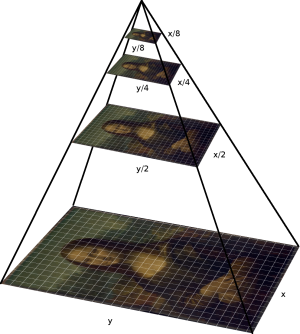

La détection des points d'intérêt se fait donc sur l'image entière $(w \times h)$, sur l'image moitié plus petite $(w/2, h/2)$ et ainsi de suite. De cette façon, même si les deux images ne sont pas à la même échelle (par exemple parce que l'homographie contenait une dilatation), on devrait pouvoir retrouver les mêmes points d'intérêt.

#### Invariance à la rotation

Une fois la détection multi-échelle réalisée, ORB va assigner à chaque point d'intérêt une orientation. Celle-ci dépendra des variations d'intensité des pixels voisins du point d'intérêt. Pour une fenêtre $I$ (un *patch*) autour d'un point d'intérêt, on définit les moments :

$$m_{pq} = \sum_{x,y} x^p y^q I(x,y)$$

Le centre de gravité (ou centre de masse) du *patch* est obtenu par :

$$C = \left(\frac{m_{10}}{m_{00}}, \frac{m_{01}}{m_{00}} \right)$$

En général le centre de gravité du *patch* va être excentré par rapport à l'origine de la fenêtre (c'est-à-dire son centre). C'est justement ce qui est intéressant car le centre de masse va permettre de localiser la direction dans laquelle l'intensité évolue le plus. On peut ensuite calculer l'angle $\theta$ formé par le segment $[O, C]$ et l'horizontal :

$$\theta = \operatorname{atan2}(m_{01}, m_{10})$$

En peut alors faire pivoter le *patch* d'un angle $-\theta$ autour de l'origine pour faire en sorte que la variation maximale d'intensité soit toujours selon l'axe horizontal. Cela permet d'obtenir une invariance aux (petites) rotations.


### Calcul des descripteurs

Comme nous l'avions remarqué tout à l'heure, BRIEF n'est pas invariant à la rotation. ORB utilise donc la variante rBRIEF (*rotation-aware* BRIEF).

Rappelons-nous que le fonctionnement de BRIEF se base sur des tests entre $n$ paires de points d'un *patch*. Notons $S$ la matrice des points constituant les paires :

$$S = \begin{bmatrix}
x_1, \ldots, x_n\\
y_1, \ldots, y_n\\
\end{bmatrix}$$

Pour un angle de rotation $\theta$, les coordonnées des points du test sont alors obtenues par $S_\theta = R_\theta S$ où $R_\theta$ est la matrice de rotation correspondante. On peut alors calculer le descripteur BRIEF selon la déviation $\theta$ estimée lors de la phase de la détection entre l'angle actuel du *patch* et son orientation canonique.

Mettons en application l'algorithme ORB sur un cas très favorable à BRIEF : l'image inversée.

In [ ]:
img_orig = rgb2gray(skimage.data.cat())
tform = transform.AffineTransform(rotation=np.pi + 0.1,
                                  scale=(1.2, 1),
                                  translation=(450, 300))
img_warped = transform.warp(img_orig, tform)
plt.imshow(img_warped, cmap="gray") and plt.show()

`ORB` est l'objet (similaire à `BRIEF`) qui implémente l'algorithme ORB dans `scikit-image`. Il faut garder en tête que ORB réalise la détection *et* l'extraction des descripteurs. Il est possible de le faire séparément mais réaliser les deux opérations simultanément est plus rapide.

In [ ]:
from skimage.feature import ORB

extractor = ORB()
extractor.detect_and_extract(img_orig)
keypoints1 = extractor.keypoints
descriptors1 = extractor.descriptors

extractor.detect_and_extract(img_warped)
keypoints2 = extractor.keypoints
descriptors2 = extractor.descriptors

matches = feature.match_descriptors(descriptors1, descriptors2)

fig, ax = plt.subplots(nrows=1, ncols=1)
plt.gray()
plot_matches(ax, img_orig, img_warped, keypoints1, keypoints2, matches)
ax.axis('off')
plt.show()

Ici, les correspondances sont très bonnes mais on peut tout de même éliminer les (rares) correspondances erronnées par RANSAC :

In [ ]:
src = keypoints1[matches[:,0]]
dst = keypoints2[matches[:,1]]
model_robust, inliers = ransac((src[:,::-1], dst[:,::-1]), transform.AffineTransform, min_samples=20,
                               residual_threshold=50, max_trials=100)

outliers = inliers == False

fig, ax = plt.subplots(nrows=2, ncols=1)
inlier_idxs = np.nonzero(inliers)[0]
plot_matches(ax[0], img_orig, img_warped, src, dst,
             np.column_stack((inlier_idxs, inlier_idxs)))
ax[0].axis('off')
ax[0].set_title('Bonnes correspondances selon RANSAC')

outlier_idxs = np.nonzero(outliers)[0]
plot_matches(ax[1], img_orig, img_warped, src, dst,
             np.column_stack((outlier_idxs, outlier_idxs)), matches_color='r')
ax[1].axis('off')
ax[1].set_title('Mauvaises correspondances selon RANSAC')

plt.show()

Puis on compare visuellement les deux images :

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
ax[0].imshow(img_orig, cmap="gray")
ax[0].set_title("Image originale")
ax[1].imshow(transform.warp(img_warped, model_robust), cmap="gray")
ax[1].set_title("Image redressée par RANSAC")
plt.show()

Cette problématique générale s'appelle *l'alignement d'images* ou *recalage*. Ce n'est pas la seule utilité des algorithmes de détection et d'extraction de points d'intérêt mais c'est une de leurs applications principales.

En recalage, on aime bien visualiser la quantité d'erreur (carré de l'écart entre l'intensité des pixel originaux et des pixels recalés) commise par la méthode en chaque point. Voici ce que cela donne pour notre exemple :

In [ ]:
realigned = transform.warp(img_warped, model_robust)
# Différence entre l'image recalée et l'image originale
diff =  realigned - img_orig

plt.imshow(np.square(diff), cmap="gray") and plt.show()

# À vous de jouer !

Expérimentez avec d'autres images et d'autres transformations. Y a-t-il des transformations que cette approche de recalage ne peut pas traiter ?